In [1]:
# !conda install scanpy muon mudata python-igraph leidenalg scikit-learn networkx jupyterlab ipywidgets scikit-image -y

# Initialization

In [2]:
import muon as mu
import scanpy as sc
import numpy as np
import networkx as nx
import time
from scipy.stats import entropy
import matplotlib.pyplot as plt

import warnings
# Ignore FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)
# Ignore UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)

from mudata import MuData # multi layer handling
from anndata import AnnData


/Users/jackpug/miniconda3/envs/bmde521/lib/python3.14/site-packages/muon/_core/preproc.py:31: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  if Version(scanpy.__version__) < Version("1.10"):


# Preprocessing

In [3]:
# preprocessing pipeline

def preprocessing(mdata, verbose=False):

    mdata.var_names_make_unique()

    # calculate QC metrics for RNA
    # based on assignment 2 - n_genes_by_counts, total_counts, pct_counts_mt
    mdata['rna'].var['mt'] = mdata['rna'].var_names.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(mdata['rna'], qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

    if(verbose == True):
        print(f"Number of cells before filtering: {mdata.shape[0]}")

    # define filters - can't remove them immediatelly or else it causes dimension issues downstream

    min_genes_mask = mdata['rna'].obs['n_genes_by_counts'] >= 200
    max_genes_mask = mdata['rna'].obs['n_genes_by_counts'] < 4000
    mt_mask = mdata['rna'].obs['pct_counts_mt'] < 6

    mdata = mdata[min_genes_mask & max_genes_mask & mt_mask, :].copy()

    if (verbose==True):
        print(f"Number of cells after filtering: {mdata.shape[0]}")

    # doublet removal
    if (verbose==True):
        print("Checking for doublets. This may take a while...")
        start_time = time.time()

    n_doublets = sc.pp.scrublet(mdata['rna'])
    mdata = mdata[mdata['rna'].obs['predicted_doublet'] == False, :].copy()

    if verbose==True:
        print(f"Doublet removal complete. Time elapsed: {time.time() - start_time} s")
        print(f"Number of cells after doublet removal: {mdata.shape[0]}") 

    # Remove genes/peaks that appear in too few cells
    sc.pp.filter_genes(mdata['rna'], min_cells=3)
    sc.pp.filter_genes(mdata['atac'], min_cells=3)

    # log norm
    sc.pp.normalize_total(mdata['rna'], target_sum=1e4)
    sc.pp.log1p(mdata['rna'])

    if (verbose==True):
        print(f"Number of genes before highly variable genes selection: {mdata['rna'].shape[1]}") 

    # filtering for highly variable genes
    sc.pp.highly_variable_genes(mdata['rna'], n_top_genes=2000, subset=True) 

    if (verbose==True):
        print(f"Number of genes after highly variable genes selection: {mdata['rna'].shape[1]}") 

    # dimensionality reduction

    # pca for rna set
    sc.pp.pca(mdata['rna'], n_comps=20)
    # tfidf and lso for atac
    mu.atac.pp.tfidf(mdata['atac'], scale_factor=1e4)
    mu.atac.tl.lsi(mdata['atac'], n_comps=20)

    # compute neighbourhood graphs

    sc.pp.neighbors(mdata['rna'], n_neighbors=30, key_added='rna')
    sc.pp.neighbors(mdata['atac'], use_rep='X_lsi', n_neighbors=30, key_added='atac')

    return mdata
    

# Entropy Weighted Fusion

In [4]:
from scipy import sparse
from sklearn.neighbors import kneighbors_graph
import torch 

# this function converts affinities into transition probabilities (Markov normalization)
def compute_transition_matrix(adj_matrix, verbose=False):

    if(verbose==True):
        print("Adjacency matrix:")
        print(adj_matrix.toarray())

    # calculate row sums 
    row_sums = np.array(adj_matrix.sum(axis=1)).flatten()
    row_sums[row_sums == 0] = 1 # prevent dividing by zero

    if(verbose==True):
        print("Row sum:")
        print(row_sums)
    

    # compute the inverse diagonal matrix using row sum reciprocals
    diagonal = sparse.diags(1.0 / row_sums)
    if(verbose==True):
        print("Diagonal matrix:")
        print(diagonal.toarray())
    
    # multiply the diagonal matrix by the adjacency matrix to perform Markov's normalization
    markov = diagonal.dot(adj_matrix)

    if(verbose==True):
        print("Markov normalized matrix:")
        print(markov.toarray())
    
    return markov


# calculate graph entropy to detect noisy cells 
def calculate_uncertainty_weights(adj_matrix, K=10, verbose=False):

    if verbose==True:
        print("Adjacency matrix:")
        print(adj_matrix.toarray())
    
    # Get probabilities
    prob = compute_transition_matrix(adj_matrix)

    if verbose==True:
        print("Probability matrix:")
        print(prob.toarray())
    
    # calculate the entropy of each row
    ent = entropy(prob.toarray().T)

    #if verbose==True:
        #print("Entropy array:")
        #print(ent)

    # scaling between 0 and 1 - this ensures differences in entropies are detected
    min_ent = np.min(ent)
    max_ent = np.max(ent)
    
    # Avoid division by zero if all entropies are identical
    if max_ent == min_ent:
        scaled_ent = np.zeros_like(ent)
        print("All entropies identical.")
    else:
        scaled_ent = (ent - min_ent) / (max_ent - min_ent)
    
    # get inverse of weights (cells with lower entropy are weighted higher)
    weights = np.exp(-scaled_ent * K) # severely punish high entropy

    if verbose==True:
        print("Weights:")
        print(weights)

    return weights

# fusion algorithm
def fuse_graphs(mdata, steps=20, verbose=False):

    # trying to speed up performance with gpu acceleration
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        print("Using Apple Metal (GPU)")
    else:
        device=torch.device("cpu")
        print("GPU not detected, falling back to CPU...")

    # first, get affinity graphs
    rna = mdata['rna'].obsp['rna_distances']
    atac = mdata['atac'].obsp['atac_distances']

    # calculate weights
    rna_weights = calculate_uncertainty_weights(rna)
    atac_weights = calculate_uncertainty_weights(atac)

    # normalize weights 
    total_weights = rna_weights + atac_weights
    norm_rna_weights = (rna_weights / total_weights)[:, None] # reshape is necessary for later steps
    norm_atac_weights = (atac_weights / total_weights)[:, None] 
    
    if verbose==True:
        print(f"New shape of rna weights array: {norm_rna_weights.shape}")
        print(f"New shape of atac weights array: {norm_atac_weights.shape}")

    print(f"Average RNA Trust: {np.mean(norm_rna_weights):.2f}")
    print(f"Average ATAC Trust: {np.mean(norm_atac_weights):.2f}")

    # rather than initializing the fused matrix to be 50/50 rna and atac, this initial guess
    # utilizes the entropy weights to weight the matrices on a per cell basis

    # the probability matrices 
    rna_prob = compute_transition_matrix(rna)
    atac_prob = compute_transition_matrix(atac)

    # move data to gpu

    rna_prob_torch = torch.tensor(rna_prob.toarray(), dtype=torch.float32, device=device)
    atac_prob_torch = torch.tensor(atac_prob.toarray(), dtype=torch.float32, device=device)

    rna_weights_torch = torch.tensor(norm_rna_weights, dtype=torch.float32, device=device)
    atac_weights_torch = torch.tensor(norm_atac_weights, dtype=torch.float32, device=device)

    # diffusion kernel
    diff = (rna_prob_torch * rna_weights_torch) + (atac_prob_torch * atac_weights_torch)
    
    fused_probability = diff.clone()

    # diffusion loop (Similarity Network Fusion)
    for i in range(steps):
        # update
        temp = torch.mm(fused_probability, diff.T)
        fused_probability = torch.mm(diff, temp)

        # can't use compute_transition_matrix directly anymore, but we still need to normalize
        row_sums = fused_probability.sum(dim=1, keepdim=True)
        row_sums[row_sums == 0] = 1.0 # Avoid div by zero
        fused_probability = fused_probability / row_sums

    return fused_probability.cpu().numpy()

# Imputation

In [5]:
# imputation is similar to MAGIC, but uses the fused graph instead of a standard markov normalized probability matrix
def impute_atac(mdata, fused_probability, t=3, verbose=False):
    """
    Formula: D_imputed = (fused_probability)^3 * D
    """

    # trying to speed up performance with gpu acceleration
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        print("Using Apple Metal (GPU)")
    else:
        device=torch.device("cpu")
        print("GPU not detected, falling back to CPU...")
    
    if verbose==True:
        start=time.time()

    # convert to tensor friendly format
    if sparse.issparse(fused_probability):
        prob_tensor = torch.tensor(fused_probability.toarray(), dtype=torch.float32, device=device)
    else:
        prob_tensor = torch.tensor(fused_probability, dtype=torch.float32, device=device)

    raw_atac = mdata['atac'].X.copy()
    if sparse.issparse(raw_atac):
        atac_tensor = torch.tensor(raw_atac.toarray(), dtype=torch.float32, device=device)
    else:
        atac_tensor = torch.tensor(raw_atac, dtype=torch.float32, device=device)

    for i in range(t):
        if(verbose==True):
            print(f"Imputation iteration {i+1} of {t}...")
        atac_tensor = torch.mm(prob_tensor, atac_tensor)

    imputed = atac_tensor.cpu().numpy()

    if verbose==True:
        print(f"Imputation time: {time.time() - start}")

    # store in mdata
    mdata['atac'].layers['imputed'] = imputed
    print("Imputation complete and stored in mdata['atac'].layers['imputed']")
    
    return imputed

# Testing

In [6]:
# testing compute_transition_matrix 
print("---Transition Matrix---\n")

test_matrix = np.array([
    [0, 2, 8],
    [5, 0, 5],
    [1, 1, 0]
])

sparse_test_matrix = sparse.csr_matrix(test_matrix)

test = compute_transition_matrix(sparse_test_matrix, verbose=True)

# works as expected!

# testing calculate_uncertainty_weights
print("\n---Weights---\n")
weights = calculate_uncertainty_weights(sparse_test_matrix, verbose=True)

# works as expected

---Transition Matrix---

Adjacency matrix:
[[0 2 8]
 [5 0 5]
 [1 1 0]]
Row sum:
[10 10  2]
Diagonal matrix:
[[0.1 0.  0. ]
 [0.  0.1 0. ]
 [0.  0.  0.5]]
Markov normalized matrix:
[[0.  0.2 0.8]
 [0.5 0.  0.5]
 [0.5 0.5 0. ]]

---Weights---

Adjacency matrix:
[[0 2 8]
 [5 0 5]
 [1 1 0]]
Probability matrix:
[[0.  0.2 0.8]
 [0.5 0.  0.5]
 [0.5 0.5 0. ]]
Weights:
[1.00000000e+00 4.53999298e-05 4.53999298e-05]


# Validation with Synthetic Data

In [7]:
# creating data that mimics data with cell types to see if pipeline can preserve cell types

from sklearn.datasets import make_blobs

# 3 cell types. rna data will have tight clusters, while atac data will have wider spread clusters (representing higher noise)

rna_mock, labels = make_blobs(n_samples=1000, n_features=3000, centers=3, cluster_std=2)
atac_mock, _ = make_blobs(n_samples=1000, n_features=10000, centers=3, cluster_std=15)

# need positive values
rna_mock = np.abs(rna_mock)
atac_mock = np.abs(atac_mock)

rna_mock_ann = AnnData(rna_mock, obs={"cell_type": labels.astype(str)})
atac_mock_ann = AnnData(atac_mock, obs={"cell_type": labels.astype(str)})
mdata_mock = MuData({"rna": rna_mock_ann, "atac": atac_mock_ann})

In [8]:
from sklearn.metrics import mean_squared_error, r2_score

def imputation_validation(mdata, fused_probability, t=3, verbose=False):
    print("Dropout Validation")

    ground_truth = mdata['atac'].X.copy()

    # next, we corrupt the data by simulating a 40% dropout
    mask = np.random.choice([0, 1], size=ground_truth.shape, p=[0.4, 0.6]) # 40% chance of 0 (dropout)
    corrupted = ground_truth.toarray() * mask

    # temporarily inject corrupted data
    mdata['atac'].X = sparse.csr_matrix(corrupted)

    if (verbose==False):
        imputed_matrix = impute_atac(mdata, fused_probability, t=t)
    else:
        imputed_matrix = impute_atac(mdata, fused_probability, t=t, verbose=True)
    # restore original data
    mdata['atac'].X = ground_truth

    # check drop out spots
    dropout_mask = (mask == 0)
    true_values = ground_truth.toarray()[dropout_mask]
    if sparse.issparse(imputed_matrix):
        imputed_values = imputed_matrix.toarray()[dropout_mask]
    else:
        imputed_values = imputed_matrix[dropout_mask]

    # now we simply compare 
    mse = mean_squared_error(true_values, imputed_values)

    # calculate what the mse would have without any fixing
    baseline_mse = mean_squared_error(true_values, np.zeros_like(true_values))

    print("Results")
    print(f"Baseline MSE: {baseline_mse:.4f}")
    print(f"Imputed MSE: {mse:.4f}")

    improvement = (baseline_mse - mse) / baseline_mse * 100
    print(f"Improvement: {improvement:.4f}%")

In [9]:
# mock data validation

mdata_mock = preprocessing(mdata_mock, verbose=True)

fused_mock = fuse_graphs(mdata_mock, steps=20, verbose=True)

imputation_validation(mdata_mock, fused_mock, t=3, verbose=True)

Number of cells before filtering: 1000
Number of cells after filtering: 1000
Checking for doublets. This may take a while...
Doublet removal complete. Time elapsed: 0.32193589210510254 s
Number of cells after doublet removal: 998
Number of genes before highly variable genes selection: 3000
Number of genes after highly variable genes selection: 2000
Using Apple Metal (GPU)
New shape of rna weights array: (998, 1)
New shape of atac weights array: (998, 1)
Average RNA Trust: 0.52
Average ATAC Trust: 0.48
Dropout Validation
Using Apple Metal (GPU)
Imputation iteration 1 of 3...
Imputation iteration 2 of 3...
Imputation iteration 3 of 3...
Imputation time: 0.06299686431884766
Imputation complete and stored in mdata['atac'].layers['imputed']
Results
Baseline MSE: 0.0029
Imputed MSE: 0.0011
Improvement: 63.1729%


# Real Data

In [10]:
# let's move on to some real data

# for this project, the Filtered feature barcode matrix (HDF5) dataset was downloaded directly from: 
# https://www.10xgenomics.com/datasets/10-k-human-pbm-cs-multiome-v-1-0-chromium-x-1-standard-2-0-0

# this dataset was placed in ./data/filtered_feature_barcode_matrix.h5

In [11]:
# load the dataset

mdata = mu.read_10x_h5("./data/filtered_feature_barcode_matrix.h5")

Added `interval` annotation for features from ./data/filtered_feature_barcode_matrix.h5


In [12]:
print(f"Keys in mdata: {list(mdata.mod.keys())}")

Keys in mdata: ['rna', 'atac']


In [13]:
# data shape
print(f"Original shape of data: {mdata.shape}")

Original shape of data: (10970, 148344)


In [14]:
mdata = preprocessing(mdata, verbose=True)

Number of cells before filtering: 10970
Number of cells after filtering: 1854
Checking for doublets. This may take a while...
Doublet removal complete. Time elapsed: 0.9100780487060547 s
Number of cells after doublet removal: 1852
Number of genes before highly variable genes selection: 18424
Number of genes after highly variable genes selection: 2000


In [15]:
fused_matrix = fuse_graphs(mdata, steps=20, verbose=True)

Using Apple Metal (GPU)
New shape of rna weights array: (1852, 1)
New shape of atac weights array: (1852, 1)
Average RNA Trust: 0.48
Average ATAC Trust: 0.52


In [16]:
imputed_matrix = impute_atac(mdata, fused_matrix, t=3, verbose=True)

Using Apple Metal (GPU)
Imputation iteration 1 of 3...
Imputation iteration 2 of 3...
Imputation iteration 3 of 3...
Imputation time: 0.5638108253479004
Imputation complete and stored in mdata['atac'].layers['imputed']


In [17]:
# we need a different validation function, as we dont want to similate dropout now

from sklearn.metrics import silhouette_score

def real_imputation_validation(mdata, fused_probability, t=3, verbose=False):
    
    # get "ground truth" labels by leiden clustering RNA
    if 'leiden' not in mdata['rna'].obs:
        print("Computing Leiden clusters.")
        sc.pp.neighbors(mdata['rna'], n_neighbors=30, key_added='rna')
        sc.tl.leiden(mdata['rna'], resolution=0.5, key_added='leiden', neighbors_key='rna')
    
    labels = mdata['rna'].obs['leiden']
    
    # apply lsi
    if 'X_lsi' not in mdata['atac'].obsm:
        mu.atac.tl.lsi(mdata['atac'], n_comps=30)

    # get silhouette score to compare ground truth to atac data (before imputation)
    raw_score = silhouette_score(mdata['atac'].obsm['X_lsi'], labels)
    
    if verbose:
        print(f"Baseline Silhouette Score: {raw_score:.4f}")

    # score imputed
    atac_imp = sc.AnnData(mdata['atac'].layers['imputed'])
    sc.pp.pca(atac_imp, n_comps=30)
    
    imp_score = silhouette_score(atac_imp.obsm['X_pca'], labels)

    if verbose:
        print(f"Imputed Silhouette Score: {imp_score:.4f}")

    improvement = (imp_score - raw_score) / raw_score * 100
    print(f"Improvement: {improvement:.2f}%")
    
    return raw_score, imp_score

In [18]:
real_imputation_validation(mdata, fused_matrix, t=10, verbose=True)

Computing Leiden clusters.
Baseline Silhouette Score: 0.0122
Imputed Silhouette Score: -0.2461
Improvement: -2123.67%


(0.012162012979388237, -0.24611948430538177)

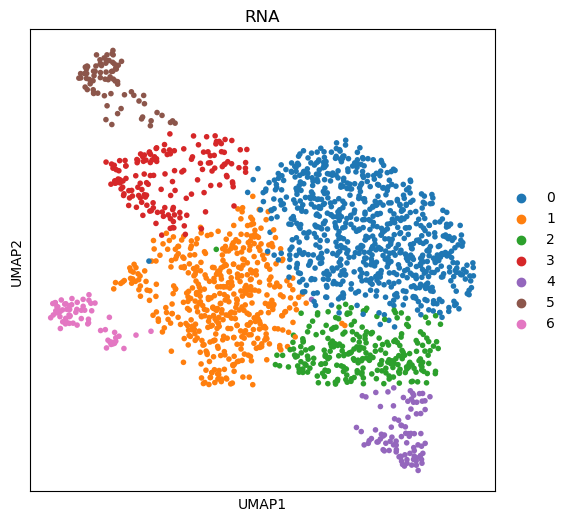

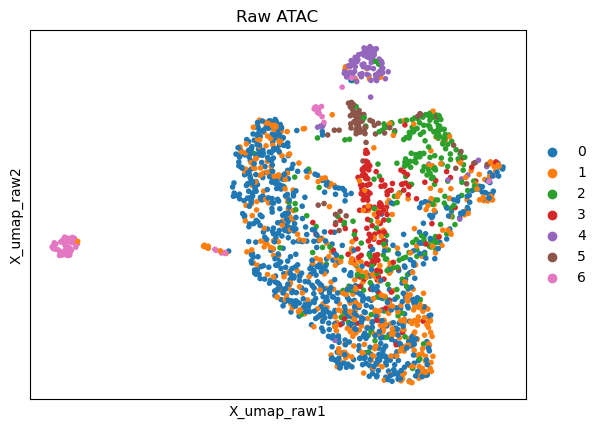

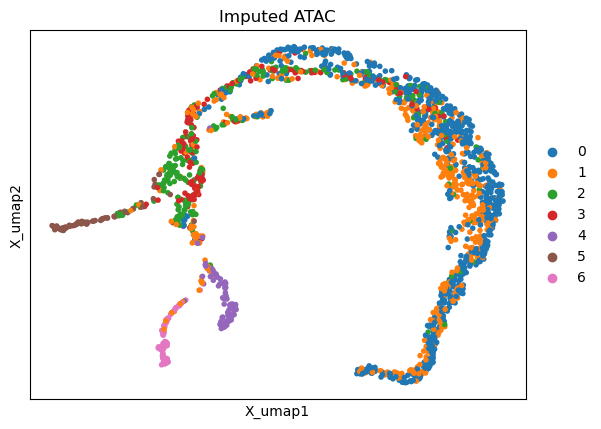

In [19]:
def visualize_umap(mdata):

    # create ground truth labels by leiden clustering rna
    if 'leiden' not in mdata['rna'].obs:
        print("Computing Leiden clusters.")
        sc.pp.neighbors(mdata['rna'], n_neighbors=30, key_added='rna')
        sc.tl.leiden(mdata['rna'], resolution=0.5, key_added='leiden', neighbors_key='rna')
    
    labels_key = 'leiden'
    sc.tl.umap(mdata['rna'], neighbors_key='rna')
    # Copy labels to atac so we can plot them there
    mdata['atac'].obs['leiden'] = mdata['rna'].obs['leiden'].copy()

    # process raw atac

    # use lsi as before because raw data is sparse
    mu.atac.tl.lsi(mdata['atac'], n_comps=30)
    sc.pp.neighbors(mdata['atac'], use_rep='X_lsi', key_added='atac_raw')
    sc.tl.umap(mdata['atac'], neighbors_key='atac_raw')

    mdata['atac'].obsm['X_umap_raw'] = mdata['atac'].obsm['X_umap'].copy()

    
    # Create a temporary anndata for the imputed layer

    atac_imputed = sc.AnnData(mdata['atac'].layers['imputed'])
    atac_imputed.obs = mdata['atac'].obs.copy() # Keep labels
    
    # Use pca for imputed data (it is dense/smooth, not sparse)
    sc.pp.pca(atac_imputed, n_comps=30)
    sc.pp.neighbors(atac_imputed, n_neighbors=30)
    sc.tl.umap(atac_imputed)

    # plot rna for reference
    fig, ax = plt.subplots(figsize=(6, 6))
    sc.pl.umap(mdata['rna'], color='leiden', ax=ax, show=False, title='RNA')
    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")

    plt.show()
    
    # Plot Raw

    sc.pl.embedding(mdata['atac'], color='leiden', basis='X_umap_raw', show=False, title='Raw ATAC')

    plt.show()
    
    # Plot Imputed

    sc.pl.embedding(atac_imputed, color='leiden',basis='X_umap',show=False, title='Imputed ATAC')

    plt.show()

# Run it
visualize_umap(mdata)

In [20]:
# showing how it was previously with cpu

def impute_atac_cpu(mdata, fused_probability, t=3, verbose=False):
    
    if verbose:
        start = time.time()

    if not sparse.issparse(fused_probability):
        P = sparse.csr_matrix(fused_probability)
    else:
        P = fused_probability

    raw_atac = mdata['atac'].X.copy()
    if not sparse.issparse(raw_atac):
        D = sparse.csr_matrix(raw_atac)
    else:
        D = raw_atac

    for i in range(t):
        if verbose:
            print(f"CPU Imputation iteration {i+1} of {t}...")
        
        D = P.dot(D)

    if sparse.issparse(D):
        imputed = D.toarray()
    else:
        imputed = D

    if verbose:
        print(f"CPU Imputation time: {time.time() - start:.4f}s")

    # Store
    mdata['atac'].layers['imputed'] = imputed
    print("CPU Imputation complete.")
    
    return imputed

In [21]:
# gpu 

imputed_matrix = impute_atac(mdata, fused_matrix, t=3, verbose=True)

Using Apple Metal (GPU)
Imputation iteration 1 of 3...
Imputation iteration 2 of 3...
Imputation iteration 3 of 3...
Imputation time: 0.5760290622711182
Imputation complete and stored in mdata['atac'].layers['imputed']


In [22]:
# cpu

imputed_matrix = impute_atac_cpu(mdata, fused_matrix, t=3, verbose=True)

CPU Imputation iteration 1 of 3...
CPU Imputation iteration 2 of 3...
CPU Imputation iteration 3 of 3...
CPU Imputation time: 1458.0112s
CPU Imputation complete.


In [23]:
gpu_time = 0.5760290622711182
cpu_time = 1458.0112

speed_increase = cpu_time / gpu_time
print(f"Speed increase: {speed_increase}x")

Speed increase: 2531.1417348483737x
